In [31]:
import os
import time
import json
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tqdm


In [2]:
# Load the JSON file
with open("nytimes_articles.json", "r") as f:
    articles = json.load(f)

# Initialize a Counter dictionary for keywords
keyword_counts = Counter()

# Loop through each article and update the keyword counts
for article in articles:
    keywords = article.get("keywords", [])
    keyword_counts.update(keywords)

# Print the top 10 most common keywords
print("Top 10 Keywords:")
for keyword, count in keyword_counts.most_common(10):
    print(f"{keyword}: {count}")

# Optionally, save the keyword counts to a file
with open("keyword_counts.json", "w") as f:
    json.dump(keyword_counts, f, indent=2)

print("Keyword counts have been saved to 'keyword_counts.json'.")


Top 10 Keywords:
Coronavirus (2019-nCoV): 22830
United States Politics and Government: 16656
Trump, Donald J: 10540
Politics and Government: 8554
Biden, Joseph R Jr: 7729
Books and Literature: 6766
Presidential Election of 2020: 6185
Content Type: Personal Profile: 5646
United States: 5645
New York City: 5217
Keyword counts have been saved to 'keyword_counts.json'.


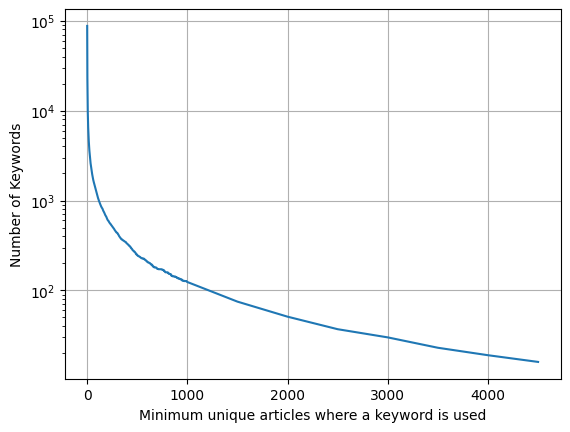

In [46]:
minimum_tag_occurences = [i for i in range(1, 1000, 2)] + [i for i in range(1000, 5000, 500)]
#minimum_tag_occurences = [i for i in range(1, 1000, 2)]

num_keywords = []

for min_occ in minimum_tag_occurences:
    keyword_count = 0
    for keyword in keyword_counts:
        if keyword_counts[keyword] >= min_occ:
            keyword_count += 1
    num_keywords.append(keyword_count)

plt.plot(minimum_tag_occurences, num_keywords)
plt.xlabel("Minimum unique articles where a keyword is used")
plt.ylabel("Number of Keywords")
plt.yscale('log')
plt.grid()
plt.show()


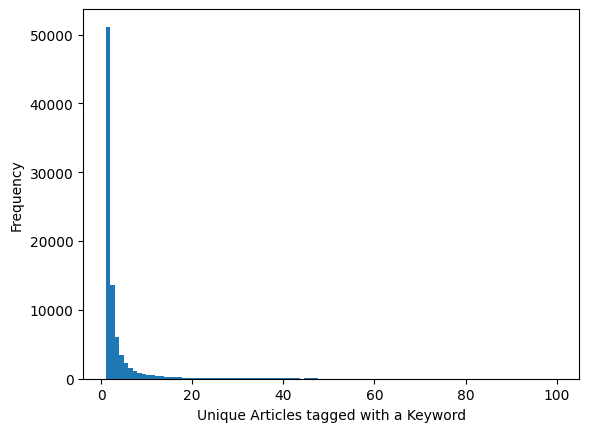

In [14]:
keywords_count_freq = []
very_frequently_used_keywords = []
very_frequent_cutoff = 1000

for keyword in keyword_counts:
    if keyword_counts[keyword] > very_frequent_cutoff:
        very_frequently_used_keywords.append(keyword_counts[keyword])
    else:
        keywords_count_freq.append(keyword_counts[keyword])

plt.hist(keywords_count_freq, bins = 100)
plt.xlabel("Unique Articles tagged with a Keyword")
plt.ylabel("Frequency")
plt.show()


In [49]:
# filtering for only commonly used tags/keywords
common_keyword_threshold = 100
common_keywords = {}

for keyword in keyword_counts:
    if keyword_counts[keyword] > common_keyword_threshold:
        common_keywords[keyword] = keyword_counts[keyword]
print(len(common_keywords))

1141


In [24]:
# Load BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')


# Generate embeddings for each tag
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

# Compute embeddings for all keywords\

embedding_length = len(get_embedding('get embedding length'))
embeddings = np.zeros((embedding_length, len(common_keywords)))

unscaled_embeddings = np.zeros((embedding_length, len(common_keywords)))


for i, keyword in enumerate(common_keywords):
    emb = np.array(get_embedding(keyword)) 
    keyword_count = common_keywords.get(keyword, 1)
    scale_factor = math.sqrt(keyword_count) 
    scaled_emb = emb * scale_factor 
    embeddings[:, i] = scaled_emb 
    unscaled_embeddings[:, i] = emb

print("Embedding matrix shape:", embeddings.shape)



Embedding matrix shape: (768, 1141)


In [64]:
scaler = StandardScaler()
embeddings_standardized = scaler.fit_transform(embeddings.T)

n_components = 100 
pca = PCA(n_components=n_components)
embeddings_pca = pca.fit_transform(embeddings_standardized)




In [67]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Transpose unscaled embeddings for comparison
unscaled_embeddings_T = unscaled_embeddings.T

# Extract principal components
principal_components = pca.components_
closest_keywords = {}

# Ensure common_keywords is a list
if isinstance(common_keywords, dict):
    keyword_list = list(common_keywords.keys())
else:
    keyword_list = common_keywords

# Iterate through principal components
for i, pc in enumerate(principal_components):
    similarities = cosine_similarity(pc.reshape(1, -1), unscaled_embeddings_T).flatten()
    closest_index = np.argmax(similarities)
    closest_keyword = keyword_list[closest_index]
    closest_keywords[f"Principal Component {i+1}"] = closest_keyword

# Output results
toplevel_keywords = []
for pc, keyword in closest_keywords.items():
    toplevel_keywords.append(keyword)

print(toplevel_keywords[:20])




['Politics and Government', 'Coronavirus Aid, Relief, and Economic Security Act (2020)', 'Coronavirus (2019-nCoV)', 'United States Politics and Government', 'Biden, Joseph R Jr', 'Books and Literature', 'Republican Party', 'New York City', 'Demonstrations, Protests and Riots', 'Content Type: Personal Profile', 'Social Media', 'Race and Ethnicity', 'New York State', 'Presidential Election of 2020', 'Immigration and Emigration', 'Economic Conditions and Trends', 'Hygiene and Cleanliness', 'Immigration and Emigration', 'United States Defense and Military Forces', 'Bronx (NYC)']


In [68]:
common_keyword_threshold = 100
common_keywords = {}

# Filter for commonly used keywords
for keyword in keyword_counts:
    if keyword_counts[keyword] > common_keyword_threshold:
        common_keywords[keyword] = keyword_counts[keyword]

# Sort the common keywords by their usage count in descending order
sorted_keywords = sorted(common_keywords.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 keywords with the most uses
top_20_keywords = sorted_keywords[:20]

# Print the result
for keyword, count in top_20_keywords:
    print(f"{keyword}: {count}")



Coronavirus (2019-nCoV): 22830
United States Politics and Government: 16656
Trump, Donald J: 10540
Politics and Government: 8554
Biden, Joseph R Jr: 7729
Books and Literature: 6766
Presidential Election of 2020: 6185
Content Type: Personal Profile: 5646
United States: 5645
New York City: 5217
Movies: 4993
Democratic Party: 4859
Republican Party: 4807
Black People: 4738
Blacks: 4738
Vaccination and Immunization: 4500
Quarantine (Life and Culture): 4481
Television: 4363
Deaths (Obituaries): 4000
Russia: 3916


In [39]:
# Failed attempt to match keywords directly with word embeddings
top_level_keywords = ['person', 'descriptor', 'location', 'organization', 'title', 'topic']

top_level_embeddings = []
for keyword in top_level_keywords:
    top_level_embeddings.append(np.array(get_embedding(keyword))) 

news_desk_filter = {'National', 'Editorial', 'Washington','Politics', 'Climate' }

for article in articles:
    if article['news_desk'] not in news_desk_filter:
        continue
    if article["abstract"] == "":
        continue
    if not article["keywords"]:
        continue
    
    keywords = article.get("keywords", [])
    for keyword in keywords:
        keyword_embedding = np.array(get_embedding(keyword))
        # Find the best top-level keyword based on cosine similarity
        best_top_level_keyword = None
        best_distance = float('inf')
        
        for i, top_level_embedding in enumerate(top_level_embeddings):
            similarity = cosine_similarity(
                keyword_embedding.reshape(1, -1), 
                top_level_embedding.reshape(1, -1)
            )[0, 0]
            
            if similarity < best_distance:
                best_distance = similarity
                best_top_level_keyword = top_level_keywords[i]
        
        # Output the best top-level keyword for the current article keyword
        print(f"Article keyword '{keyword}' best matches top-level keyword '{best_top_level_keyword}' with similarity {best_distance:.4f}")


Article keyword 'Churches (Buildings)' best matches top-level keyword 'topic' with similarity 0.3535
Article keyword 'Murders, Attempted Murders and Homicides' best matches top-level keyword 'person' with similarity 0.3158
Article keyword 'West Freeway Church of Christ (White Settlement, Tex)' best matches top-level keyword 'topic' with similarity 0.3293
Article keyword 'Fort Worth (Tex)' best matches top-level keyword 'organization' with similarity 0.4220
Article keyword 'White Settlement (Tex)' best matches top-level keyword 'descriptor' with similarity 0.4625
Article keyword 'Texas' best matches top-level keyword 'descriptor' with similarity 0.5702
Article keyword 'Veterans' best matches top-level keyword 'descriptor' with similarity 0.5904
Article keyword 'For-Profit Schools' best matches top-level keyword 'topic' with similarity 0.4807
Article keyword 'Financial Aid (Education)' best matches top-level keyword 'topic' with similarity 0.5102
Article keyword 'Frauds and Swindling' be

KeyboardInterrupt: 

In [28]:

sorted_keywords = sorted(common_keywords.items(), key=lambda item: item[1], reverse=True)
print("Most common keywords in order:")
for keyword, count in sorted_keywords:
    print(f"{keyword}: {count}")



Most common keywords in order:
Coronavirus (2019-nCoV): 22830
United States Politics and Government: 16656
Trump, Donald J: 10540
Politics and Government: 8554
Biden, Joseph R Jr: 7729
Books and Literature: 6766
Presidential Election of 2020: 6185
Content Type: Personal Profile: 5646
United States: 5645
New York City: 5217
Movies: 4993
Democratic Party: 4859
Republican Party: 4807
Black People: 4738
Blacks: 4738
Vaccination and Immunization: 4500
Quarantine (Life and Culture): 4481
Television: 4363
Deaths (Obituaries): 4000
Russia: 3916
Russian Invasion of Ukraine (2022): 3574
United States Economy: 3549
United States International Relations: 3544
Content Type: Service: 3421
Social Media: 3364
Real Estate and Housing (Residential): 3214
Women and Girls: 3177
China: 3159
Computers and the Internet: 3107
Art: 3104
Discrimination: 2959
Ukraine: 2959
Quarantines: 2778
Race and Ethnicity: 2622
Global Warming: 2609
Theater: 2572
Coronavirus Reopenings: 2502
Senate: 2492
Law and Legislation: 

In [33]:

relevant_tag_index = {}
for c, keyword in enumerate(common_keywords):
    relevant_tag_index[keyword] = c

In [34]:
# exclusive use matrix
# For N tags this is a N x N matrix where
# the ith, jth entry is the number of times the ith tag is used as the keyword in an article
# without the jth tag

# time complexity ==> yes




exclusive_use_matrix = np.zeros((len(common_keywords), len(common_keywords)))
for article in tqdm.tqdm(articles):
    keywords = article.get("keywords", [])
    relevant_article_keywords = set()
    for tag in keywords:
        if tag in common_keywords:
            relevant_article_keywords.add(tag)

    for t1 in relevant_article_keywords:
        for t2 in common_keywords:
            if t2 in relevant_article_keywords:
                continue
            else:
                exclusive_use_matrix[relevant_tag_index[t1], relevant_tag_index[t2]] += 1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 141340/141340 [02:52<00:00, 820.35it/s]


In [60]:
us_econ_ind = relevant_tag_index['United States Economy']
inflation_ind = relevant_tag_index['Inflation (Economics)']
print(exclusive_use_matrix[us_econ_ind, inflation_ind])
print(exclusive_use_matrix[inflation_ind, us_econ_ind])

social_media_ind = relevant_tag_index["Social Media"]
tiktok = relevant_tag_index['TikTok (ByteDance)']
print(exclusive_use_matrix[social_media_ind, tiktok])
print(exclusive_use_matrix[tiktok, social_media_ind])

print(exclusive_use_matrix[social_media_ind, tiktok]/ common_keywords['Social Media'] )
print(exclusive_use_matrix[tiktok, social_media_ind]/ common_keywords['TikTok (ByteDance)'])

2708.0
450.0
2978.0
104.0
0.8852556480380499
0.21224489795918366


In [57]:
top_level_tags = {}
top_level_tag_threshold = 1000
exclusive_use_thresh = .3
for t1 in relevant_tag_index:
    if common_keywords[t1] > top_level_tag_threshold:
        top_level_tags[t1] = []
    else:
        continue
    for t2 in relevant_tag_index:
        if t1 == t2:
            continue
        exlusive_use = exclusive_use_matrix[relevant_tag_index[t2], relevant_tag_index[t1]]
        if exlusive_use / common_keywords[t2] < exclusive_use_thresh:
            print(f"{t2} is likely a subclass of {t1}")
            top_level_tags[t1].append(t2)
            

Arbery, Ahmaud (1994-2020) is likely a subclass of Murders, Attempted Murders and Homicides
Abbott, Gregory W (1957- ) is likely a subclass of Texas
Trump-Ukraine Whistle-blower Complaint and Impeachment Inquiry is likely a subclass of Trump, Donald J
Mar-a-Lago (Palm Beach, Fla) is likely a subclass of Trump, Donald J
Bolton, John R is likely a subclass of Trump, Donald J
Pompeo, Mike is likely a subclass of Trump, Donald J
Russian Interference in 2016 US Elections and Ties to Trump Associates is likely a subclass of Trump, Donald J
Impeachment is likely a subclass of Trump, Donald J
Republican National Committee is likely a subclass of Trump, Donald J
Suleimani, Qassim is likely a subclass of Trump, Donald J
Pence, Mike is likely a subclass of Trump, Donald J
Presidential Election of 2016 is likely a subclass of Trump, Donald J
Cheney, Liz is likely a subclass of Trump, Donald J
Special Prosecutors (Independent Counsel) is likely a subclass of Trump, Donald J
Barr, William P is likel

In [63]:

total_inferred_subclasses = 0
for tag in top_level_tags:
    print(f"{tag}: {top_level_tags[tag]}")
    total_inferred_subclasses += len(top_level_tags[tag])
print(top_level_tags["Social Media"])
print(common_keywords["Social Media"])
print(f"Inferred superclasses count: {len(top_level_tags)}")
print(f"Inferred subclasses count: {total_inferred_subclasses}")

Murders, Attempted Murders and Homicides: ['Arbery, Ahmaud (1994-2020)']
Texas: ['Abbott, Gregory W (1957- )']
Colleges and Universities: []
Regulation and Deregulation of Industry: []
Trump, Donald J: ['Trump-Ukraine Whistle-blower Complaint and Impeachment Inquiry', 'Mar-a-Lago (Palm Beach, Fla)', 'Bolton, John R', 'Pompeo, Mike', 'Russian Interference in 2016 US Elections and Ties to Trump Associates', 'Impeachment', 'Republican National Committee', 'Suleimani, Qassim', 'Pence, Mike', 'Presidential Election of 2016', 'Cheney, Liz', 'Special Prosecutors (Independent Counsel)', 'Barr, William P', 'Kushner, Jared', 'Trump Tax Returns', 'Giuliani, Rudolph W', 'Electoral College', 'Subpoenas', 'Trump Organization', 'Presidential Election of 2024', 'Meadows, Mark R (1959- )', 'Republican National Convention', 'Raffensperger, Brad', 'White House Coronavirus Outbreak (2020)', 'House Select Committee to Investigate the January 6th Attack']
United States Politics and Government: ['Trump-Ukrai